In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
# download ชุดข้อมูลและ save เข้าไฟล์
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\PROJECTLAB\\.keras\\datasets\\auto-mpg.data'

In [5]:
# ใช้ pandas อ่านข้อมูลจากไฟล์ csv และเก็บเข้า raw_dataset

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
#ุดข้อมูลเราเป็น object ประเภท pandas DataFrame
type(dataset)

pandas.core.frame.DataFrame

In [7]:
# หาจํานวนเซล์ที่ไม่มีข้อมูล
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
# ดร๊อปแถวที่มีเซล์ที่ไม่มีข้อมูล ออกจาก dataset
dataset = dataset.dropna()

In [9]:
dataset['Origin']

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: Origin, Length: 392, dtype: int64

In [10]:
# เปลี่ยน Label ของ origin จากตัวเลขเป็น string 1='USA' 2='Europe' 3='Japn'
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset['Origin']

0         USA
1         USA
2         USA
3         USA
4         USA
        ...  
393       USA
394    Europe
395       USA
396       USA
397       USA
Name: Origin, Length: 392, dtype: object

In [17]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA


In [11]:
dataset = pd.get_dummies(dataset)

In [12]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_Europe,Origin_Japan,Origin_USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [13]:
# เตรียมชุดข้อมูลแยกเป็นสองชุด train_dataset (ใช้สําหรับ train neural network) และก็ test_data (ใช้ทดสอบประสิทธิภาพ neural network) 
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

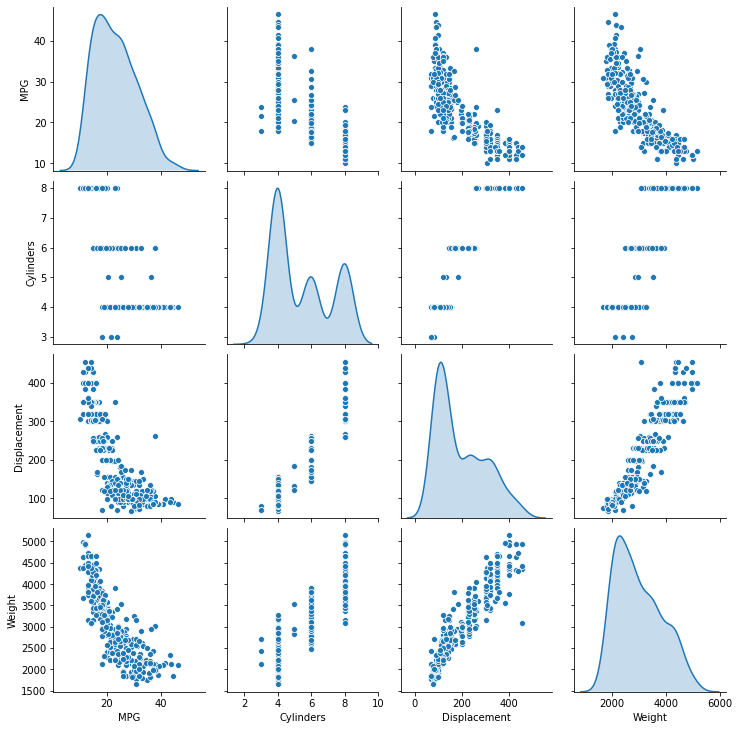

In [14]:
# plot ดูการแปรฝันระหว่างแต่ละตัวแปรในชุดข้อมูล
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [15]:
#ใช้ function .describe() เพื่อดูสติถิของชุดข้อมูล
train_stats = train_dataset.describe()
train_stats.pop('MPG')

# transpose ก็คือแค่การสลับ row กับ column ในตะราง
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin_Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Origin_Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
Origin_USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [16]:
# เอาชุดข้อมูล MPG - miles per gallon ออกเพราะอันนี้คือ target ที่เราจะพยายาม predict
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [17]:
# normalise ข้อมูล magnitude ของ ทุก variable นั้นจะวัดเป็นหน่วย standard deviation ของชุดข้อมูลตัวเอง
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [18]:
# ใช้ keras สร้างโมเดล layer 1 มี 64 neuron layer 2 มี 64 neuron และ layer 3 มี 1 neuron, ที่ layer สุดท้ายมี 1 neuron เพราะ ouput ของ neural netowrk คือ mpg
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    #ใช้้ keras optimizer เพื่อปรับ learning rate โดยอัตโนมัติเพื่อให้การเรียนรู้เร็วขึ้น
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    # สร้าง โมเดลด้วยคํําสั่ง compile
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [19]:
# จํานวน input features 
len(train_dataset.keys())

9

In [20]:
# รันฟังชั่น build_model() เพื่อสร้างและรับ model เข้าตัวแปร model
model = build_model()

In [21]:
# ตรวจสอบคุณสมบัติของโมเดล 
# จํานวน parameter = จํานวน neuron x จํานวน input + จํานวน nueron 
# layer 1 704 parameter มาจาก 64 * 10 + 64 = 704, 
# layer 2 มี 4160 parameter มาจาก 64*64 + 64 =4160, 
# layer 3 มี 65 parameter มาจาก 64*1 + 1=65

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [22]:
# ดึงข้อมูลมา 5 row

example_batch = normed_train_data[:5]
example_batch

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_Europe,Origin_Japan,Origin_USA
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,-0.465148,-0.495225,0.774676
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,-0.465148,-0.495225,0.774676
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,-0.465148,-0.495225,0.774676
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,-0.465148,-0.495225,0.774676
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-0.465148,2.012852,-1.286751


In [23]:
# ลองใช้ model predict ผลจากชุดข้อมูล ผบนั้นควรที่จะผิดเพราะเรายังไม่ได้ train model

example_result = model.predict(example_batch)
example_result

array([[ 0.1766375 ],
       [ 0.2832539 ],
       [ 0.09951449],
       [ 0.26853925],
       [-0.13195597]], dtype=float32)

In [24]:
# ทําการ training โมเดล โดยแบ่งข้อมูลสําหรับ test เป็น 20% จากชุดข้อมูล
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:566.6959,  mae:22.5013,  mse:566.6959,  val_loss:557.9580,  val_mae:22.2625,  val_mse:557.9580,  
....................................................................................................
Epoch: 100, loss:6.0417,  mae:1.7311,  mse:6.0417,  val_loss:8.1557,  val_mae:2.1943,  val_mse:8.1557,  
....................................................................................................
Epoch: 200, loss:5.2562,  mae:1.5679,  mse:5.2562,  val_loss:8.2266,  val_mae:2.2579,  val_mse:8.2266,  
....................................................................................................
Epoch: 300, loss:4.6708,  mae:1.4798,  mse:4.6708,  val_loss:7.6139,  val_mae:2.0901,  val_mse:7.6139,  
....................................................................................................
Epoch: 400, loss:4.3174,  mae:1.3873,  mse:4.3174,  val_loss:7.8986,  val_mae:2.1908,  val_mse:7.8986,  
..............................................................

In [25]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

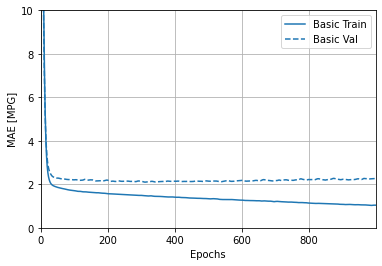

In [26]:
# plot ดูผล accuracy ของ training
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

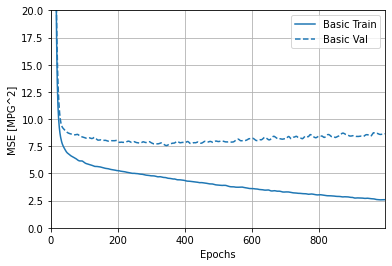

In [27]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [29]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.9539 - mae: 2.0921 - mse: 6.9539
Testing set Mean Abs Error:  2.09 MPG


In [30]:
model = build_model()

# สร้าง callback ที่จะทําหน้าที่หยุดการ training เมื่อ val_loss ไม่ดีขึ้น
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# ทําการ training และใส่ callback เข้าไปใน model.fit() 
early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:557.7072,  mae:22.3277,  mse:557.7072,  val_loss:537.8835,  val_mae:21.8728,  val_mse:537.8834,  
...............................................................

Text(0, 0.5, 'MAE [MPG]')

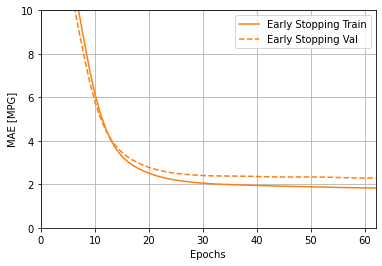

In [31]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [32]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.6713 - mae: 1.7931 - mse: 5.6713
Testing set Mean Abs Error:  1.79 MPG


In [46]:
# run ข้อมูล prediction จาก model ที่ train แล้ว
test_predictions = model.predict(normed_test_data)
test_predictions = test_predictions.flatten() # flatten ให้เป็น aray 1 มิติ
test_predictions

array([15.789362 , 11.258482 , 12.136391 , 23.264812 , 21.889908 ,
       12.731144 , 12.998074 , 12.877298 , 19.700806 , 28.449959 ,
       25.11288  , 24.969858 , 14.9143095, 27.041826 , 12.115782 ,
       13.981586 , 13.982191 , 12.910185 , 18.905212 , 12.330387 ,
       14.236649 , 25.367275 , 19.892712 , 20.740921 , 29.33289  ,
       23.351336 , 16.37465  , 22.37413  , 17.105549 , 19.542166 ,
       27.07433  , 20.859688 , 18.92218  , 21.18777  , 26.045332 ,
       15.77766  , 19.319958 , 31.447878 , 30.110813 , 17.247036 ,
       30.387514 , 28.486235 , 15.770317 , 35.82486  , 35.12832  ,
       35.592293 , 20.201475 , 22.323734 , 20.515245 , 25.418959 ,
       30.96434  , 17.704462 , 31.771431 , 18.24567  , 17.603245 ,
       17.859228 , 32.97292  , 34.133896 , 22.193325 , 24.710405 ,
       38.2582   , 32.942055 , 27.687908 , 27.470995 , 32.57663  ,
       39.12216  , 36.454933 , 35.371204 , 33.293556 , 29.754654 ,
       22.010456 , 23.45309  , 29.589153 , 30.510487 , 36.0284

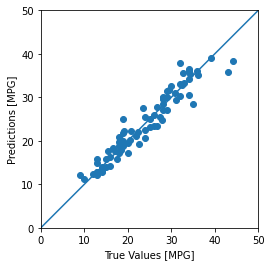

In [54]:
# plot ดูผล test_label แทียบกับ test_prediction ถ้า prediction และ reality ตรงกัน จุด scatter plot จะอยู่บนเส้นเฉียงพอดี

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')

# plot เส้นเฉียง
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)


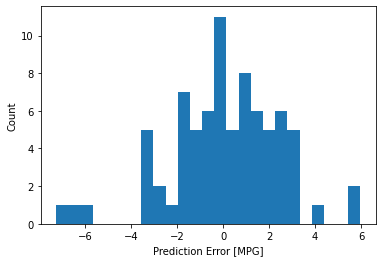

In [64]:
# ตรวจสอบ error ของ prediction ใน histogram plot

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")